In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Bert_Lime/SNLI/

In [ ]:
!pip install transformers
!pip install seqeval datasets allennlp
!pip install flax
!pip install sentencepiece
!pip install nltk
!pip install gensim

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_datasets.text import Snli
import os

In [ ]:
from __future__ import division

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()

        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.
        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size
        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor
        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
ac_dict = {"neutral" : 1, "entailment" : 0, "contradiction" : 2}

In [ ]:
import os
from operator import itemgetter    
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

# from keras import models, regularizers, layers, optimizers, losses, metrics
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras.utils import to_categorical
# from keras.layers import LayerNormalization
import tensorflow as tf
from tensorflow.keras.datasets import imdb

In [ ]:
import torch

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
print(len(ac_dict))

In [ ]:
model_version = 'bert-base-cased'
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch

In [ ]:
from huggingface_hub import create_repo

In [ ]:

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained(model_version,
                                          bos_token = "[CLS]",
                                          eos_token = "[SEP]")
transformer_model = AutoModel.from_pretrained(model_version, output_attentions = True).to(device)
linear_layer = nn.Linear(transformer_model.config.hidden_size,
                         len(ac_dict)).to(device)
cross_entropy_layer = nn.CrossEntropyLoss()
normalizing_layer = Sparsemax(dim = 1)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# # del transformer_model
# del optimizer

In [ ]:
print(transformer_model.config.hidden_size)

768


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
from tqdm import tqdm

In [ ]:
from typing import List, Tuple

In [ ]:
def pad_batch(elems: List[List[int]], pad_token_id: int) -> List[List[int]]:
    """Pads all lists in elems to the maximum list length of any list in 
    elems. Pads with pad_token_id.
    """
    max_len = max([len(elem) for elem in elems])
    return [elem+[pad_token_id]*(max_len-len(elem)) for elem in elems]

def load_dataset(tokenizer):
  train, test = tfds.as_numpy(tfds.load("Snli", split=['train', 'test']))

  parts = []

  new_train_data = []
  train_labels = []
  cnt = 0
  for tokenized_text in tqdm(train):
    # cnt += 1
    # if(cnt >= 10000):
    #   break
    decoded_sent = "[CLS] " +  str(tokenized_text["hypothesis"])[2:-1] + " [SEP] " + str(tokenized_text["premise"])[2:-1] + " [SEP]"
    # print(decoded_sent)
    new_encoded_text = tokenizer.encode(decoded_sent)
    if(tokenized_text["label"] < 0 or tokenized_text["label"] > 2):
      continue
    new_train_data.append(new_encoded_text)
    train_labels.append(tokenized_text["label"])
  
  new_test_data = []
  test_labels = []
  for tokenized_text in tqdm(test):
    decoded_sent = "[CLS] " +  str(tokenized_text["hypothesis"])[2:-1] + " [SEP] " + str(tokenized_text["premise"])[2:-1] + " [SEP]"
    # print(decoded_sent)
    new_encoded_text = tokenizer.encode(decoded_sent)
    if(tokenized_text["label"] < 0 or tokenized_text["label"] > 2):
      continue
    new_test_data.append(new_encoded_text)
    test_labels.append(tokenized_text["label"])


  return (new_train_data, train_labels), (new_test_data, test_labels)

def generator(dataset_data, dataset_label, max_len = 512, batch_size = 16):
  i = 0
  tokenized_threads, labels = [], []
  while i<len(dataset_data):
    tokenized_threads.append(dataset_data[i][:max_len])
    labels.append(dataset_label[i])
    i += 1
        
    if i%batch_size==0:
      yield (pad_batch(tokenized_threads, tokenizer.pad_token_id), 
                  labels)
      tokenized_threads, labels = [], []

In [ ]:
from itertools import chain

import torch.optim as optim

optimizer = optim.Adam(params = chain(transformer_model.parameters(),
                                      linear_layer.parameters()),
                       lr = 2e-5)

In [ ]:
def train(dataset_data, dataset_label, batch_size):
    global values_weight, values_bias;
    accumulate_over = 32
    
    optimizer.zero_grad()
    print("Training")
    for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label,  batch_size = batch_size)):
        
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        labels = torch.tensor(labels, device=device, dtype=torch.long)


        loss = compute((tokenized_threads, 
                        labels,), False)

        print("\rLoss: ", loss.item(), end = " ")

        loss.backward()

        if i%accumulate_over==accumulate_over-1:
            optimizer.step()
            optimizer.zero_grad()
    
    optimizer.step()

In [ ]:
from datasets import load_metric
metric1 = load_metric("accuracy")
metric3 = load_metric("precision", average = "micro")
metric2 = load_metric("f1", average = "micro")
metric4 = load_metric("recall", average = "micro")
metric5 = load_metric("precision", average = "macro")
metric6 = load_metric("f1", average = "macro")
metric7 = load_metric("recall", average = "macro")


Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

In [ ]:
def evaluate(dataset_data, dataset_label, BATCH_SIZE):
    
    int_to_labels = {v:k for k, v in ac_dict.items()}
    print('Evaluation')
    
    with torch.no_grad():
        for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE)):
            # print(comp_type_labels)
            #Cast to PyTorch tensor
            tokenized_threads = torch.tensor(tokenized_threads, device=device)
            labels = torch.tensor(labels, device=device)

            preds = compute((tokenized_threads, 
                            labels,), pred=True)
            loss = compute((tokenized_threads, labels,), pred = False)
            
            metric1.add_batch(predictions=preds, 
                            references=labels,)
                            #tokenized_threads=tokenized_threads.cpu().tolist())
            metric2.add_batch(predictions=preds, 
                            references=labels,)
            metric3.add_batch(predictions=preds, 
                            references=labels,)
            metric4.add_batch(predictions=preds, 
                            references=labels,)
            metric5.add_batch(predictions=preds, 
                            references=labels,)
            metric6.add_batch(predictions=preds, 
                            references=labels,)
            metric7.add_batch(predictions=preds, 
                            references=labels,)
            
            print("\rLoss: ", loss.item(), end = " ")
    print(metric1.compute())
    print("Micro")
    print(metric2.compute(average = "micro"))
    print(metric3.compute(average = "micro"))
    print(metric4.compute(average = "micro"))
    print("Macro")
    print(metric5.compute(average = "macro"))
    print(metric6.compute(average = "macro"))
    print(metric7.compute(average = "macro"))

In [ ]:

(train_dataset_data, train_dataset_label), (test_dataset_data, test_dataset_label) = load_dataset(tokenizer)

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: snli/1.1.0
INFO:absl:Load dataset info from /tmp/tmp0_s8w833tfds
INFO:absl:Generating dataset snli (/root/tensorflow_datasets/snli/1.1.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://nlp.stanford.edu/projects/snli/snli_1.0.zip into /root/tensorflow_datasets/downloads/nlp.stanford.edu_projects_snli_snli_1.0lceV-Gb3o-4MBUJuSsg6Kd3hE-FmgJE4Efz14V_hwbc.zip.tmp.791ad3909cda4feea3856819a34ef956...
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/snli/1.1.0.incompleteU9SVL1/snli-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/snli/1.1.0.incompleteU9SVL1/snli-test.tfrecord. Shard lengths: [10000]
INFO:absl:Generating split validation


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/snli/1.1.0.incompleteU9SVL1/snli-validation.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/snli/1.1.0.incompleteU9SVL1/snli-validation.tfrecord. Shard lengths: [10000]
INFO:absl:Generating split train


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/snli/1.1.0.incompleteU9SVL1/snli-train.tfrecord


  0%|          | 0/550152 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/snli/1.1.0.incompleteU9SVL1/snli-train.tfrecord. Shard lengths: [550152]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from /root/tensorflow_datasets/snli/1.1.0


Dataset snli downloaded and prepared to /root/tensorflow_datasets/snli/1.1.0. Subsequent calls will reuse this data.


550152it [07:22, 1244.30it/s]
10000it [00:10, 974.33it/s]


In [ ]:
def compute(batch: Tuple[torch.Tensor, torch.Tensor], pred: bool=True):
    """
    Args:
        batch:  A tuple having tokenized thread of shape [batch_size, seq_len],
                component type labels of shape [batch_size, seq_len], and a global
                attention mask for Longformer, of the same shape.
        
        
        cross_entropy:  This argument will only be used if preds=False, i.e., if 
                        loss is being calculated. If True, then cross entropy loss
                        will also be added to the output loss.
    
    Returns:
        Either the predicted sequences with their scores for each element in the batch
        (if preds is True), or the loss value summed over all elements of the batch
        (if preds is False).
    """
    tokenized_threads, labels = batch
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, torch.tensor(1).to(device), torch.tensor(0).to(device))
    x = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)
#     print(tokenized_threads.shape)
#     print(x[0].last_hidden_state, x[1].shape, len(x[2]))
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[0][:, 0, :])

    logits = normalizing_layer(logits)
    if(pred):
      return torch.argmax(logits, dim = 1)

    ce_loss = cross_entropy_layer(logits, labels)

    return ce_loss

In [ ]:
import numpy as np
def shuffle(data, labels):
  idx = np.random.permutation(len(data))
  x,y = np.array(data)[idx], np.array(labels)[idx]
  return x.tolist(), y.tolist()

In [ ]:
BATCH_SIZE = 32

In [ ]:
print(tokenizer.decode([101]))

[CLS]


In [ ]:
print(device)

cuda:0


In [ ]:
import pickle


In [ ]:
linear_path = "Model_sparsemax/linear_layer.pt"
cross_path = "Model_sparsemax/cross_entropy_layer.pt"
tokenizer_path = "Model_sparsemax/tokenizer_pre.pkl"
transformer_path = "Model_sparsemax/transformer_layer.pt"
offset_path = "Model_sparsemax/offset.pkl"

In [ ]:
train_dataset_data, train_dataset_label = shuffle(train_dataset_data, train_dataset_label)
test_dataset_data, test_dataset_label = shuffle(test_dataset_data, test_dataset_label)
X_train, Y_train = train_dataset_data, train_dataset_label
X_test, Y_test = test_dataset_data, test_dataset_label

In [ ]:
with open(offset_path, "rb") as f:
    offset = pickle.load(f)
print(offset)

320000


In [ ]:
n_epochs = 2
step = 64000
with open(offset_path, "rb") as f:
      offset = pickle.load(f)

for epoch in range(n_epochs):
    print(f"------------EPOCH {epoch+1}---------------")
    #loading data
    with open(offset_path, "rb") as f:
      offset = pickle.load(f)
    linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
    cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
    transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
    with open(tokenizer_path, "rb") as f:
      tokenizer = pickle.load(f)

    while(offset <= len(X_train)):

      #training and evaluating 
      print("Train")
      train(X_train[offset: offset + step], Y_train[offset: offset + step], BATCH_SIZE)
      print("Test accuracy")
      evaluate(X_test, Y_test, BATCH_SIZE)

      offset += step
      #save model
      torch.save(linear_layer.state_dict(), linear_path)
      torch.save(cross_entropy_layer.state_dict(), cross_path)
      torch.save(transformer_model.state_dict(), transformer_path)
      with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)
      
      #saving offset
      with open(offset_path, "wb") as f:
        pickle.dump(offset, f)

Streaming output truncated to the last 5000 lines.
Loss (test) :  0.36450040340423584
Loss (test) :  0.28977060317993164
Loss (test) :  0.23053091764450073
Loss (test) :  0.3540761172771454
Loss (test) :  0.3392754793167114
Loss (test) :  0.40105265378952026
Loss (test) :  0.3682842552661896
Loss (test) :  0.4103429913520813
Loss (test) :  0.40669381618499756
Loss (test) :  0.737333357334137
Loss (test) :  0.27975234389305115
Loss (test) :  0.5916191935539246
Loss (test) :  0.32765352725982666
Loss (test) :  0.29364264011383057
Loss (test) :  0.43630921840667725
Loss (test) :  0.47191962599754333
Loss (test) :  0.6246451735496521
Loss (test) :  0.4014597237110138
Loss (test) :  0.2719500958919525
Loss (test) :  0.3797719180583954
Loss (test) :  0.47156012058258057
Loss (test) :  0.38473138213157654
Loss (test) :  0.38880228996276855
Loss (test) :  0.38078948855400085
Loss (test) :  0.3630693256855011
Loss (test) :  0.2797088027000427
Loss (test) :  0.39765265583992004
Loss (test) :  0.

KeyboardInterrupt: ignored

In [ ]:
print(offset)

320000


In [ ]:
print(len(test_dataset_label))

9824


In [ ]:
test_dataset_data, test_dataset_label = shuffle(test_dataset_data,  test_dataset_label)
evaluate(test_dataset_data, test_dataset_label, BATCH_SIZE)


In [ ]:
print(test_dataset_label)

[2, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 2, 0, 2, 2, 1, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 0, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 2, 2, 0, 2, 2, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0, 0, 1, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 1, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 2, 2, 2, 1, 1, 0, 2, 1, 0, 1, 0, 0, 

In [ ]:
# torch.save(linear_layer.state_dict(), linear_path)
# torch.save(cross_entropy_layer.state_dict(), cross_path)
# torch.save(transformer_model.state_dict(), transformer_path)
# with open(tokenizer_path, "wb") as f:
#   pickle.dump(tokenizer, f)

In [ ]:
linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
with open(tokenizer_path, "rb") as f:
  tokenizer = pickle.load(f)

In [ ]:
from multiprocessing import Process, Manager, Array
manager = Manager()

In [ ]:
graph_attention = []
for i in range(12):
  graph_attention.append({})
mapping_ind = {}
rev_mapping_ind = {}

In [ ]:
cnt = 0
threshold = 0.01

In [ ]:
import multiprocessing as mp
from tqdm import tqdm

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:


my_arr = [1 for i in range(100)]

def func(i, j , k):
    global my_arr
    my_arr[i] = 3
    

indexes = [(i, i, i) for i in range(12)]
pool = mp.Pool(min(12, mp.cpu_count()))
pool.starmap(func, indexes)
pool.close()

In [ ]:
type(mp.cpu_count())

int

In [ ]:
temp_attention = []
def init_arr(arr):
    globals()['arr'] = arr
from copy import deepcopy
def store_attention(lay, j, tokens):
        
    global mapping_ind, graph_attention, temp_attention;
    maximum_attention = np.max(temp_attention)
    weights = temp_attention[j, lay, :, :]
    temp_dict = {}
    for ind_1 in range(len(tokens)):
        for ind_2 in range(len(tokens)):
            if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                continue
            node_1 = mapping_ind[tokens[ind_1]]
            node_2 = mapping_ind[tokens[ind_2]]
            weight = weights[ind_1, ind_2]
            if(weight < threshold*maximum_attention):
                continue
            if(node_1 not in temp_dict):
                temp_dict[node_1] = {}
            
            if(node_2  not in temp_dict[node_1]):
                temp_dict[node_1][node_2] = (weight, 1)
            else:
                temp_dict[node_1][node_2] = (weight*temp_dict[node_1][node_2][1]/(temp_dict[node_1][node_2][1] + 1), temp_dict[node_1][node_2][1] + 1)
    graph_attention[lay] = deepcopy(temp_dict)
#     print(graph_attention)
def attention_graph(dataset_data, dataset_label, BATCH_SIZE):
    
    
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i, (tokenized_threads, labels) in tqdm(enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE))):
    
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        temp_attention = attention[:, :, :, :]
        maximum_attention = np.max(attention)
        for j, tokenized_thread in enumerate(tokenized_threads):
            tokens = tokenizer.convert_ids_to_tokens(tokenized_thread) 
            print(len(tokens))
            print(tokenized_thread.shape)
            for tok in tokens:
                if(tok not in mapping_ind):
                    mapping_ind[tok] = cnt;
                    cnt += 1
            
    for i, (tokenized_threads, labels) in tqdm(enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE))):
    
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        temp_attention = attention[:, :, :, :]
        maximum_attention = np.max(attention)
        for j, tokenized_thread in enumerate(tokenized_threads):
            tokens = tokenizer.convert_ids_to_tokens(tokenized_thread) 

#             params = [(i1, j, tokens) for i1 in range(12)]
#             pool = mp.Pool(min(12, mp.cpu_count()))
#             pool.starmap(store_attention, params)
#             pool.close()
            for lay in range(12):
                weights = attention[j, lay, :, :]
                for ind_1 in range(len(tokens)):
                    for ind_2 in range(len(tokens)):
                        if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                            continue

                        node_1 = mapping_ind[tokens[ind_1]]
                        node_2 = mapping_ind[tokens[ind_2]]
                        weight = weights[ind_1, ind_2]
                        if(weight < threshold*maximum_attention):
                            continue
                        if(node_1 not in graph_attention[lay]):
                            graph_attention[lay][node_1] = {}
                        if(node_2  not in graph_attention[lay][node_1]):
                            graph_attention[lay][node_1][node_2] = (weight, 1)
                        else:
                            graph_attention[lay][node_1][node_2] = ((weight + (graph_attention[lay][node_1][node_2][0])*graph_attention[lay][node_1][node_2][1])/(graph_attention[lay][node_1][node_2][1] + 1), graph_attention[lay][node_1][node_2][1] + 1)
#         print(cnt, cnt**2)              


In [ ]:
def extract_data(dataset_data, dataset_label, BATCH_SIZE):
    example = [[], [], []]
    for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE)):
        for j in range(BATCH_SIZE):
            if(len(example[0]) < 5 or len(example[1]) < 5 or len(example[2]) < 5):
                example[labels[j]].append((tokenizer.convert_ids_to_tokens(tokenized_threads[j]), tokenized_threads[j]))
            else:
                break
    return example

In [ ]:
text = extract_data(test_dataset_data, test_dataset_label, BATCH_SIZE)

In [ ]:
import random

In [ ]:
def find_degree(nodes, graph):
    out_degree = {}
    in_degree = {}
    for node_1 in graph:
        for node_2 in graph[node_1]:
            if(node_1 not in out_degree):
                out_degree[node_1] = 0
            if(node_2 not in in_degree):
                in_degree[node_2] = 0;
            in_degree[node_2] += 1;
            out_degree[node_1] += 1;
    ret_out = [out_degree[i] for i in nodes]
    ret_in = [in_degree[i] for i in nodes]
    return ret_out, ret_in
def find_topk_tokens(graph, k):
    attention = {}
    attention_inward = {}
    for node_1 in graph:
        if(node_1 not in attention):
            attention[node_1] = (0, 0)
        for node_2 in graph[node_1]:
            
            if(node_2 not in attention_inward):
                attention_inward[node_2] = (0, 0)
            attention[node_1] = ((graph[node_1][node_2][0] + (attention[node_1][0])*attention[node_1][1])/(attention[node_1][1] + 1), attention[node_1][1] + 1)
            attention_inward[node_2] = ((graph[node_1][node_2][0] + (attention_inward[node_2][0])*attention_inward[node_2][1])/(attention_inward[node_2][1] + 1), attention_inward[node_2][1] + 1)
    out_max = [i[0] for i in find_maxk(attention, k)]
    in_max = [i[0] for i in find_maxk(attention_inward, k)]
    return in_max, out_max, [i[1] for i in find_maxk(attention_inward, k)], [i[1] for i in find_maxk(attention, k)], find_mink(attention, k)[0][1], find_mink(attention_inward, k)[0][1]
def find_mink(attention, k):
    ret = []
    for i in attention:
        if(i == mapping_ind["[CLS]"] or i == mapping_ind["[SEP]"]):
            continue
        ret.append((i, attention[i][0]))
    ret.sort(key = lambda x: x[1])
    return ret[:k]
def find_maxk(attention, k):
    ret = []
    for i in attention:
        if(i == mapping_ind["[CLS]"] or i == mapping_ind["[SEP]"]):
            continue
        ret.append((i, attention[i][0]))
    ret.sort(key = lambda x: x[1])
    ret.reverse()
    return ret[:k]

In [ ]:
def remove_pad(given_s):
    l = given_s.split()
    ret = []
    for i in l:
        if(i != "[PAD]"):
            ret.append(i)
    return " ".join(ret)

In [ ]:
def replacing(tok_mapping, tokenized_thread, tokens):
    ret_tokenized_thread = tokenized_thread.clone()
    ind = []
    for i in range(len(tokens)):
        if(mapping_ind[tokens[i]] in tok_mapping):
            ret_tokenized_thread[0, i] = tokenizer.encode(tok_mapping[mapping_ind[tokens[i]]])[1];
            ind.append(i)
    return ret_tokenized_thread, ind

In [ ]:
vocab_dict = tokenizer.get_vocab()

In [ ]:

vocab = []
for i in vocab_dict:
  if(i not in ["[CLS]", '[PAD]', '[SEP]']):
    vocab.append(i)



In [ ]:
import random
def create_mapping(tok, ind):
    ret_dict = {}
    for k, i in enumerate(tok):
        if((k + i) < len(vocab)):
            ret_dict[i] = vocab[k + ind]
        else:
            ret_dict[i] = random.choice(vocab)
        ret_dict[i] = random.choice(vocab)
    return ret_dict

In [ ]:
def get_embedding(ind, tokenized):
    pad_mask = torch.where(tokenized!=tokenizer.pad_token_id, 1, 0)
    embedding = transformer_model(input_ids=tokenized,attention_mask=pad_mask,).last_hidden_state
    ret_embedding = []
    for i in ind:
        ret_embedding.append(embedding[:, i, :].reshape((embedding.shape[2])))
    return ret_embedding

In [ ]:
replacement = 100
trials = 3
trial_candidate = 5
select_max = 5

In [ ]:
print(len(text[1]))

3


In [ ]:
import matplotlib.pyplot as plt
from scipy import spatial
text[0] = text[0][:3]
text[1] = text[1][:3]
text[2] = text[2][:3]

In [ ]:
def predict_proba(tokenized_threads):
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,attention_mask=pad_mask,).last_hidden_state[:, 0, :])
    logits = torch.exp(logits)
    z = torch.sum(logits)
    logits = torch.divide(logits, z)
    return logits
def mask_out_top5(text_lab, label, label_ind, flag):
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i1, (tokens, tokenized_threads) in enumerate(text_lab):
        print("\n\n\n")
        print("###### Example :", str(i1), "label", label, "########")
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device).reshape((1, len(tokenized_threads)))
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
        
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        graph = dict()
        
        for tok in tokens:
            if(tok not in mapping_ind):
                mapping_ind[tok] = cnt;
                cnt += 1

        for lay in range(12):
            weights = attention[0, lay, :, :]
            for ind_1 in range(len(tokens)):
                for ind_2 in range(len(tokens)):
                    if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                        continue
                    node_1 = mapping_ind[tokens[ind_1]]
                    node_2 = mapping_ind[tokens[ind_2]]
                    rev_mapping_ind[node_1] = tokens[ind_1]
                    rev_mapping_ind[node_2] = tokens[ind_2]
                    weight = weights[ind_1, ind_2]
                    if(node_1 not in graph):
                        graph[node_1] = {}
                    if(node_2  not in graph[node_1]):
                        graph[node_1][node_2] = (weight, 1)
                    else:
                        graph[node_1][node_2] = ((weight + (graph[node_1][node_2][0])*graph[node_1][node_2][1])/(graph[node_1][node_2][1] + 1), graph[node_1][node_2][1] + 1)

        topk_in, topk_out, topk_in_attention, topk_out_attention, topk_in_min, topk_out_min  = find_topk_tokens(graph, select_max)

        
        candidate = random.sample(topk_in, trial_candidate)
        for j in range(trials):
            random.shuffle(vocab)
            print([ rev_mapping_ind[z] for z in candidate], "\n")
            in_logits_l2_norm = []
            for l in tqdm(range(0, min(len(vocab), 1000), select_max)):
                top5_in_mapping = create_mapping(candidate, l)

                example_in, ind_in = replacing(top5_in_mapping, tokenized_threads, tokens)

                actual_in = get_embedding(ind_in, tokenized_threads)
                replaced_in = get_embedding(ind_in, example_in)

                if(len(ind_in) >= 1):
                    final_actual_in = torch.divide(sum(actual_in),len(actual_in)).cpu().detach().numpy()
                    final_replaced_in = torch.divide(sum(replaced_in) , len(replaced_in)).cpu().detach().numpy()
                else:
                    continue
                if(predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind] < 0.5):
                    continue
                subtract_in = np.subtract(final_actual_in, final_replaced_in)
                if(flag == "L2"):
                    in_logits_l2_norm.append((np.linalg.norm(subtract_in), predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind]))
                elif(flag == "Cosine"):
                    in_logits_l2_norm.append((spatial.distance.cosine(final_actual_in, final_replaced_in), predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind]))
                    
                    
            in_logits_l2_norm.sort(key = lambda x : x[0])
            

            plt.scatter([i[0] for i in in_logits_l2_norm],[i[1] for i in in_logits_l2_norm])
        print("| Min:", topk_in_min)
        for i in range(len(topk_in)):
            print("Token:", rev_mapping_ind[topk_in[i]], "| attention:", topk_in_attention[i])
        plt.title('Example ' + str(i) + ' in')
        plt.xlabel(flag + ' norm')
        plt.ylabel('probability of '+ label )
        plt.show()
        plt.clf()
        
        candidate = random.sample(topk_out, trial_candidate)
        for j in range(trials):

            random.shuffle(vocab)
            print([ rev_mapping_ind[z] for z in candidate], "\n")
            out_logits_l2_norm = []
            for l in tqdm(range(0, min(len(vocab), 1000), select_max)):
                top5_out_mapping = create_mapping([j], l)

                
                
                example_out, ind_out = replacing(top5_out_mapping, tokenized_threads, tokens)

                actual_out = get_embedding(ind_out, tokenized_threads)
                replaced_out = get_embedding(ind_out, example_out)
#                 print(sum(actual_out))
                if(len(ind_out) >= 1):
                    final_actual_out = torch.divide(sum(actual_out) , len(actual_out)).cpu().detach().numpy()
                    final_replaced_out = torch.divide(sum(replaced_out) , len(replaced_out)).cpu().detach().numpy()
                else:
                    continue
                if(predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind] < 0.50):
                    continue    
                subtract_out = np.subtract(final_actual_out, final_replaced_out)
                if(flag == "L2"):
                    out_logits_l2_norm.append((np.linalg.norm(subtract_out), predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind]))
                elif(flag == "Cosine"):
                    out_logits_l2_norm.append((spatial.distance.cosine(final_actual_out, final_replaced_out), predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind]))
                    
            out_logits_l2_norm.sort(key = lambda x : x[0])
            
            plt.scatter([i[0] for i in out_logits_l2_norm],[i[1] for i in out_logits_l2_norm])

        print("| Min:", topk_out_min)
        for i in range(len(topk_out)):
            print("Token:", rev_mapping_ind[topk_out[i]], "| attention:", topk_out_attention[i])
        plt.title('Example ' + str(i) + ' out')
        plt.xlabel(flag + ' norm')
        plt.ylabel('probability of ' + label )
        plt.show()
        plt.clf()





###### Example : 0 label neutral ########
['balloon', 'entertaining', 'girl', '##ula', '.'] 



100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


['balloon', 'entertaining', 'girl', '##ula', '.'] 



100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


['balloon', 'entertaining', 'girl', '##ula', '.'] 



100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


| Min: 0.027839532746084836
Token: balloon | attention: 0.04076990285767448
Token: . | attention: 0.03552064569138733
Token: entertaining | attention: 0.033773111545413396
Token: ##ula | attention: 0.031588579243475974
Token: girl | attention: 0.03150961075662182


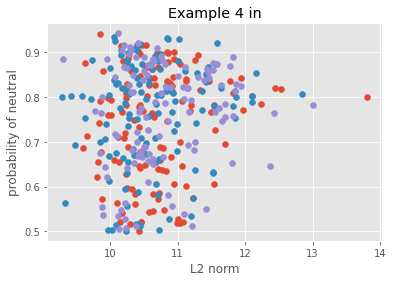

['ho', 'background', 'balloon', 'h', '##ops'] 



100%|██████████| 200/200 [00:29<00:00,  6.88it/s]


['ho', 'background', 'balloon', 'h', '##ops'] 



100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


['ho', 'background', 'balloon', 'h', '##ops'] 



100%|██████████| 200/200 [00:26<00:00,  7.66it/s]


| Min: 0.018158672504186558
Token: h | attention: 0.03199517881858879
Token: ho | attention: 0.03197241362560987
Token: ##ops | attention: 0.03141097684046779
Token: balloon | attention: 0.03131437442361626
Token: background | attention: 0.031091418182451012


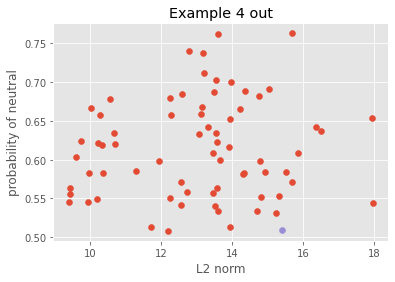





###### Example : 1 label neutral ########
['posing', 'walkway', 'large', 'pictures', 'taking'] 



100%|██████████| 200/200 [00:33<00:00,  6.03it/s]


['posing', 'walkway', 'large', 'pictures', 'taking'] 



100%|██████████| 200/200 [00:33<00:00,  6.06it/s]


['posing', 'walkway', 'large', 'pictures', 'taking'] 



100%|██████████| 200/200 [00:32<00:00,  6.16it/s]


| Min: 0.025650491095903713
Token: walkway | attention: 0.04642340832070716
Token: pictures | attention: 0.045192636570006085
Token: taking | attention: 0.03303489898992408
Token: large | attention: 0.0324150648247694
Token: posing | attention: 0.03223654583304477


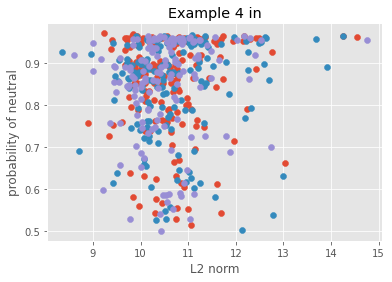

['people', 'water', 'taking', 'large', 'pictures'] 



100%|██████████| 200/200 [00:30<00:00,  6.50it/s]


['people', 'water', 'taking', 'large', 'pictures'] 



100%|██████████| 200/200 [00:34<00:00,  5.78it/s]


['people', 'water', 'taking', 'large', 'pictures'] 



100%|██████████| 200/200 [00:17<00:00, 11.71it/s]


| Min: 0.017707375624374508
Token: pictures | attention: 0.035341924579881126
Token: taking | attention: 0.03431173251077005
Token: people | attention: 0.03226017963240189
Token: large | attention: 0.03221425583221227
Token: water | attention: 0.03175705721063802


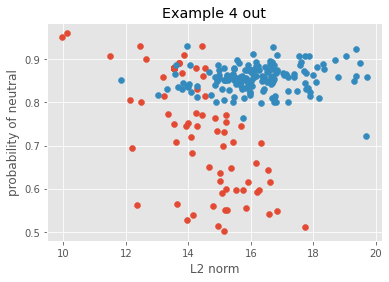





###### Example : 2 label neutral ########
['Many', 'aren', 'each', 'says', 'talking'] 



100%|██████████| 200/200 [00:31<00:00,  6.44it/s]


['Many', 'aren', 'each', 'says', 'talking'] 



100%|██████████| 200/200 [00:30<00:00,  6.52it/s]


['Many', 'aren', 'each', 'says', 'talking'] 



100%|██████████| 200/200 [00:30<00:00,  6.58it/s]


| Min: 0.018001589351312977
Token: talking | attention: 0.029815128299607647
Token: says | attention: 0.028370880451627722
Token: Many | attention: 0.026523143349288535
Token: aren | attention: 0.024537781504977214
Token: each | attention: 0.02444909165447108


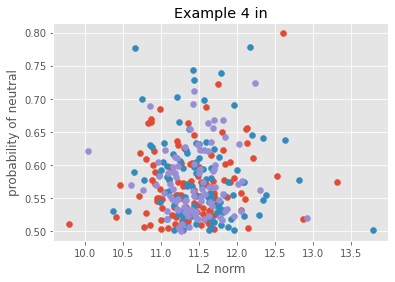

['##O', '##IN', 'P', '##I', 'H'] 



100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


['##O', '##IN', 'P', '##I', 'H'] 



100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


['##O', '##IN', 'P', '##I', 'H'] 



100%|██████████| 200/200 [00:17<00:00, 11.71it/s]


| Min: 0.012473983396079939
Token: ##I | attention: 0.022696516371187588
Token: ##O | attention: 0.022540087367775265
Token: ##IN | attention: 0.022260389739738602
Token: H | attention: 0.022217438739582488
Token: P | attention: 0.02194568520919372


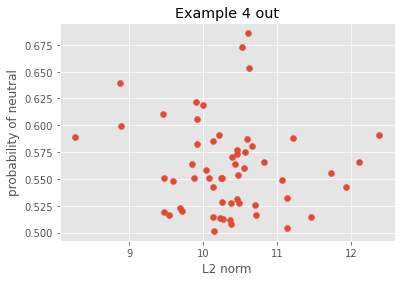

<Figure size 432x288 with 0 Axes>

In [ ]:

mask_out_top5(text[0], "neutral", 0, "L2")





###### Example : 0 label entailment ########
['ready', 'feeding', '.', 'horse', 'horses'] 



100%|██████████| 200/200 [00:31<00:00,  6.28it/s]


['ready', 'feeding', '.', 'horse', 'horses'] 



100%|██████████| 200/200 [00:32<00:00,  6.20it/s]


['ready', 'feeding', '.', 'horse', 'horses'] 



100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


| Min: 0.04007891157840978
Token: ready | attention: 0.05012984005709326
Token: horses | attention: 0.04812274528011425
Token: feeding | attention: 0.04562778342799901
Token: . | attention: 0.0439723089738367
Token: horse | attention: 0.04321022603334814


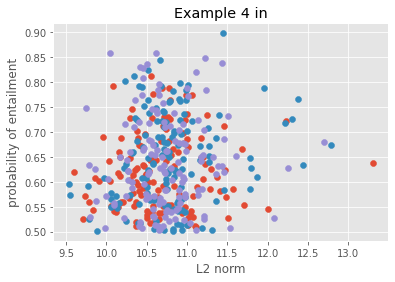

['horse', 'ride', 'feeding', 'to', 'ready'] 



100%|██████████| 200/200 [00:28<00:00,  6.91it/s]


['horse', 'ride', 'feeding', 'to', 'ready'] 



100%|██████████| 200/200 [00:17<00:00, 11.54it/s]


['horse', 'ride', 'feeding', 'to', 'ready'] 



100%|██████████| 200/200 [00:17<00:00, 11.57it/s]


| Min: 0.026928254881552347
Token: feeding | attention: 0.047406851330682294
Token: ride | attention: 0.046847829068528635
Token: ready | attention: 0.04640629159828475
Token: horse | attention: 0.04581101563510022
Token: to | attention: 0.04521189197107055


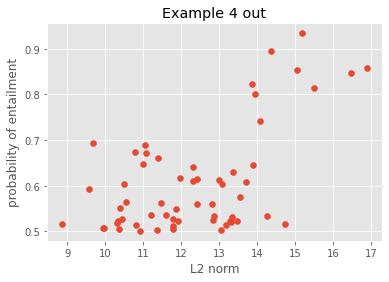





###### Example : 1 label entailment ########
['mother', 'sits', 'toy', 'couch', '.'] 



100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


['mother', 'sits', 'toy', 'couch', '.'] 



100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


['mother', 'sits', 'toy', 'couch', '.'] 



100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


| Min: 0.02434537234454928
Token: couch | attention: 0.0465687579811568
Token: sits | attention: 0.04170999715850775
Token: mother | attention: 0.033444577367360964
Token: toy | attention: 0.03149434153531572
Token: . | attention: 0.029980308645015084


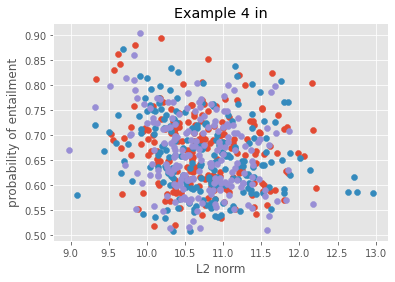

['mother', 'sits', 'his', 'on', 'watches'] 



100%|██████████| 200/200 [00:34<00:00,  5.88it/s]


['mother', 'sits', 'his', 'on', 'watches'] 



100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


['mother', 'sits', 'his', 'on', 'watches'] 



100%|██████████| 200/200 [00:17<00:00, 11.66it/s]


| Min: 0.016034192552525136
Token: mother | attention: 0.030468147715286983
Token: watches | attention: 0.030310317421553067
Token: on | attention: 0.030242847413022786
Token: his | attention: 0.029878103137249402
Token: sits | attention: 0.029748132417634486


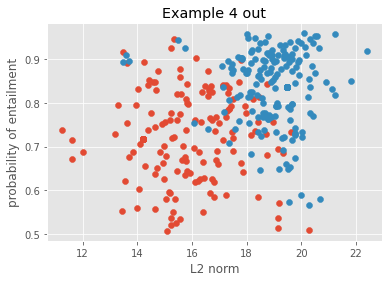





###### Example : 2 label entailment ########
['throws', 'enjoys', 'brown', 'grassy', 'dogs'] 



100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


['throws', 'enjoys', 'brown', 'grassy', 'dogs'] 



100%|██████████| 200/200 [00:28<00:00,  6.91it/s]


['throws', 'enjoys', 'brown', 'grassy', 'dogs'] 



100%|██████████| 200/200 [00:29<00:00,  6.83it/s]


| Min: 0.03310311080688284
Token: grassy | attention: 0.052148828992219044
Token: dogs | attention: 0.04240817899452956
Token: throws | attention: 0.04198017465635017
Token: enjoys | attention: 0.041836097236366665
Token: brown | attention: 0.03969097343227117


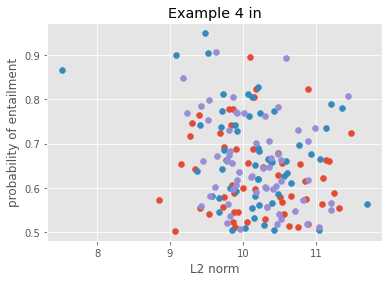

['field', 'throws', 'group', 'stick', 'three'] 



100%|██████████| 200/200 [00:34<00:00,  5.88it/s]


['field', 'throws', 'group', 'stick', 'three'] 



100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


['field', 'throws', 'group', 'stick', 'three'] 



100%|██████████| 200/200 [00:17<00:00, 11.55it/s]


| Min: 0.020573350381831047
Token: field | attention: 0.04093803330828163
Token: group | attention: 0.040334544268692915
Token: throws | attention: 0.03842530028488154
Token: three | attention: 0.0377171575485282
Token: stick | attention: 0.037714289269829705


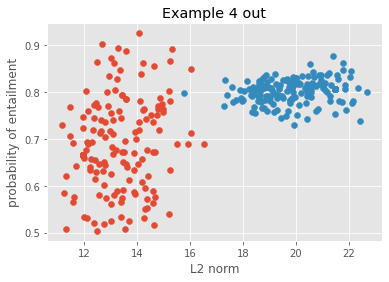

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[1], "entailment", 1, "L2",)





###### Example : 0 label contradiction ########
['kids', 'related', 'very', 'emotional', 'youths'] 



100%|██████████| 200/200 [00:30<00:00,  6.61it/s]


['kids', 'related', 'very', 'emotional', 'youths'] 



100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


['kids', 'related', 'very', 'emotional', 'youths'] 



100%|██████████| 200/200 [00:30<00:00,  6.51it/s]


| Min: 0.02712838744282837
Token: emotional | attention: 0.04470819089540806
Token: related | attention: 0.03850161612666976
Token: kids | attention: 0.037807782396420964
Token: youths | attention: 0.03610767640374678
Token: very | attention: 0.034322224720395096


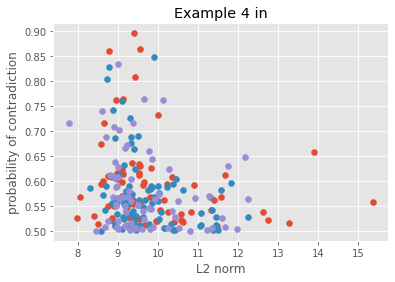

['1', 'looking', 'are', 'with', 'them'] 



100%|██████████| 200/200 [00:29<00:00,  6.69it/s]


['1', 'looking', 'are', 'with', 'them'] 



100%|██████████| 200/200 [00:18<00:00, 11.07it/s]


['1', 'looking', 'are', 'with', 'them'] 



100%|██████████| 200/200 [00:18<00:00, 11.08it/s]


| Min: 0.019413457945082573
Token: 1 | attention: 0.032436888179008104
Token: them | attention: 0.032421198822471395
Token: are | attention: 0.03241444411930384
Token: with | attention: 0.03221437368908179
Token: looking | attention: 0.0318276013384602


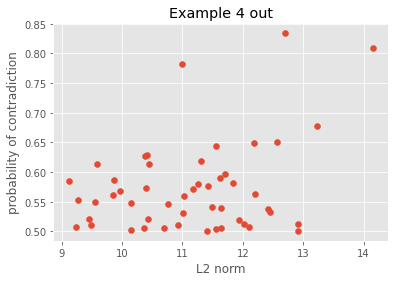





###### Example : 1 label contradiction ########
['shirt', 'blond', 'white', 'wearing', 'shorts'] 



100%|██████████| 200/200 [00:36<00:00,  5.50it/s]


['shirt', 'blond', 'white', 'wearing', 'shorts'] 



100%|██████████| 200/200 [00:35<00:00,  5.59it/s]


['shirt', 'blond', 'white', 'wearing', 'shorts'] 



100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


| Min: 0.02285472532371754
Token: blond | attention: 0.03674857174959557
Token: shirt | attention: 0.03548495524157451
Token: shorts | attention: 0.03537967512428578
Token: white | attention: 0.034306185806836115
Token: wearing | attention: 0.0322777709403757


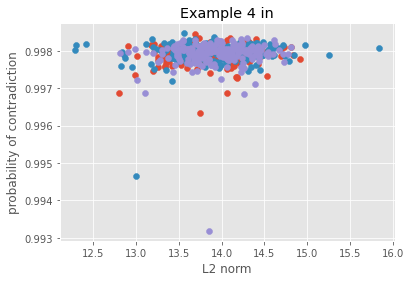

['white', 'sky', 'black', 'shorts', 'water'] 



100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


['white', 'sky', 'black', 'shorts', 'water'] 



100%|██████████| 200/200 [00:34<00:00,  5.74it/s]


['white', 'sky', 'black', 'shorts', 'water'] 



100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


| Min: 0.014573194864188697
Token: white | attention: 0.0313230215112115
Token: black | attention: 0.030697207617879866
Token: water | attention: 0.03038908545203667
Token: shorts | attention: 0.030009657799132863
Token: sky | attention: 0.02973122899934312


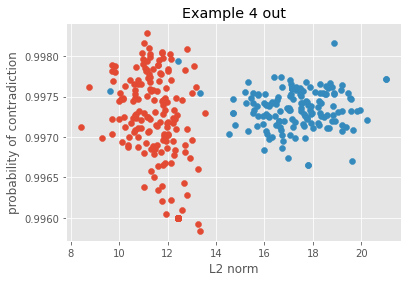





###### Example : 2 label contradiction ########
['dog', 'shorts', 'blue', 'wearing', '.'] 



100%|██████████| 200/200 [00:34<00:00,  5.74it/s]


['dog', 'shorts', 'blue', 'wearing', '.'] 



100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


['dog', 'shorts', 'blue', 'wearing', '.'] 



100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


| Min: 0.03543986169216665
Token: shorts | attention: 0.05015926381563991
Token: wearing | attention: 0.04487756059744557
Token: dog | attention: 0.04337546417420318
Token: blue | attention: 0.04214548678831607
Token: . | attention: 0.03871311038265285


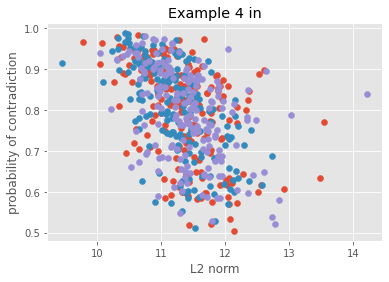

['dog', 'walking', '##rill', 'g', 'blue'] 



100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


['dog', 'walking', '##rill', 'g', 'blue'] 



100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


['dog', 'walking', '##rill', 'g', 'blue'] 



100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


| Min: 0.025797275538033307
Token: blue | attention: 0.044302236610586555
Token: g | attention: 0.04286069845749445
Token: ##rill | attention: 0.04227746182052774
Token: walking | attention: 0.04213871151098835
Token: dog | attention: 0.04208212343247379


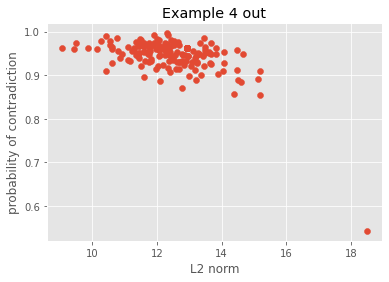

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[2], "contradiction", 2, "L2",)





###### Example : 0 label neutral ########
['.', '##ula', 'girl', 'balloon', 'entertaining'] 



100%|██████████| 200/200 [00:32<00:00,  6.20it/s]


['.', '##ula', 'girl', 'balloon', 'entertaining'] 



100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


['.', '##ula', 'girl', 'balloon', 'entertaining'] 



100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


| Min: 0.027839532746084836
Token: balloon | attention: 0.04076990285767448
Token: . | attention: 0.03552064569138733
Token: entertaining | attention: 0.033773111545413396
Token: ##ula | attention: 0.031588579243475974
Token: girl | attention: 0.03150961075662182


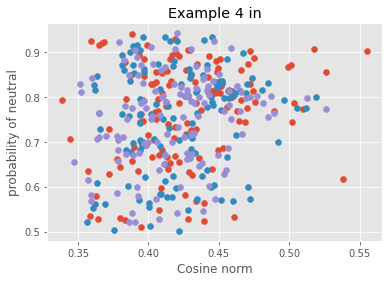

['h', '##ops', 'ho', 'balloon', 'background'] 



100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


['h', '##ops', 'ho', 'balloon', 'background'] 



100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


['h', '##ops', 'ho', 'balloon', 'background'] 



100%|██████████| 200/200 [00:26<00:00,  7.63it/s]


| Min: 0.018158672504186558
Token: h | attention: 0.03199517881858879
Token: ho | attention: 0.03197241362560987
Token: ##ops | attention: 0.03141097684046779
Token: balloon | attention: 0.03131437442361626
Token: background | attention: 0.031091418182451012


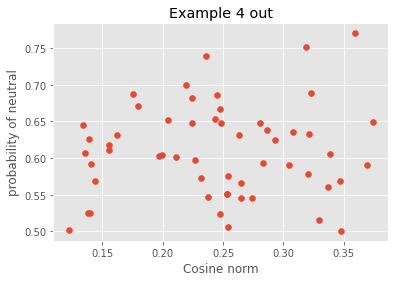





###### Example : 1 label neutral ########
['large', 'posing', 'pictures', 'walkway', 'taking'] 



100%|██████████| 200/200 [00:33<00:00,  5.96it/s]


['large', 'posing', 'pictures', 'walkway', 'taking'] 



100%|██████████| 200/200 [00:37<00:00,  5.29it/s]


['large', 'posing', 'pictures', 'walkway', 'taking'] 



100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


| Min: 0.025650491095903713
Token: walkway | attention: 0.04642340832070716
Token: pictures | attention: 0.045192636570006085
Token: taking | attention: 0.03303489898992408
Token: large | attention: 0.0324150648247694
Token: posing | attention: 0.03223654583304477


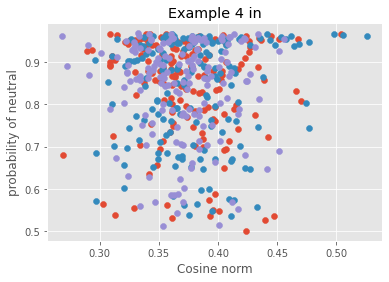

['water', 'large', 'people', 'taking', 'pictures'] 



100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


['water', 'large', 'people', 'taking', 'pictures'] 



100%|██████████| 200/200 [00:47<00:00,  4.24it/s]


['water', 'large', 'people', 'taking', 'pictures'] 



100%|██████████| 200/200 [00:23<00:00,  8.36it/s]


| Min: 0.017707375624374508
Token: pictures | attention: 0.035341924579881126
Token: taking | attention: 0.03431173251077005
Token: people | attention: 0.03226017963240189
Token: large | attention: 0.03221425583221227
Token: water | attention: 0.03175705721063802


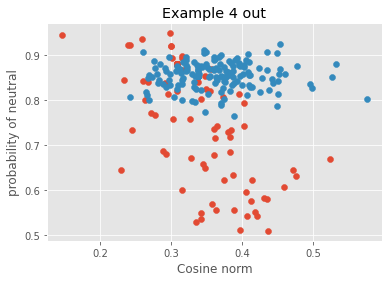





###### Example : 2 label neutral ########
['talking', 'aren', 'Many', 'says', 'each'] 



100%|██████████| 200/200 [00:42<00:00,  4.72it/s]


['talking', 'aren', 'Many', 'says', 'each'] 



100%|██████████| 200/200 [00:43<00:00,  4.59it/s]


['talking', 'aren', 'Many', 'says', 'each'] 



100%|██████████| 200/200 [00:38<00:00,  5.17it/s]


| Min: 0.018001589351312977
Token: talking | attention: 0.029815128299607647
Token: says | attention: 0.028370880451627722
Token: Many | attention: 0.026523143349288535
Token: aren | attention: 0.024537781504977214
Token: each | attention: 0.02444909165447108


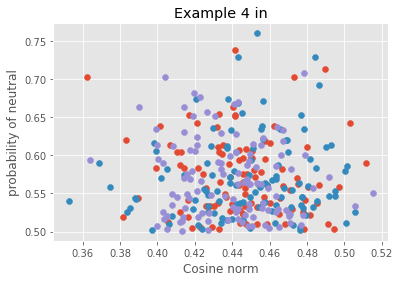

['P', '##I', 'H', '##O', '##IN'] 



100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


['P', '##I', 'H', '##O', '##IN'] 



100%|██████████| 200/200 [00:17<00:00, 11.65it/s]


['P', '##I', 'H', '##O', '##IN'] 



100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


| Min: 0.012473983396079939
Token: ##I | attention: 0.022696516371187588
Token: ##O | attention: 0.022540087367775265
Token: ##IN | attention: 0.022260389739738602
Token: H | attention: 0.022217438739582488
Token: P | attention: 0.02194568520919372


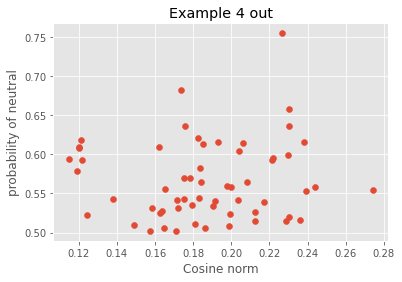

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[0], "neutral", 0, "Cosine")





###### Example : 0 label entailment ########
['ready', '.', 'horse', 'feeding', 'horses'] 



100%|██████████| 200/200 [00:32<00:00,  6.06it/s]


['ready', '.', 'horse', 'feeding', 'horses'] 



100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


['ready', '.', 'horse', 'feeding', 'horses'] 



100%|██████████| 200/200 [00:32<00:00,  6.16it/s]


| Min: 0.04007891157840978
Token: ready | attention: 0.05012984005709326
Token: horses | attention: 0.04812274528011425
Token: feeding | attention: 0.04562778342799901
Token: . | attention: 0.0439723089738367
Token: horse | attention: 0.04321022603334814


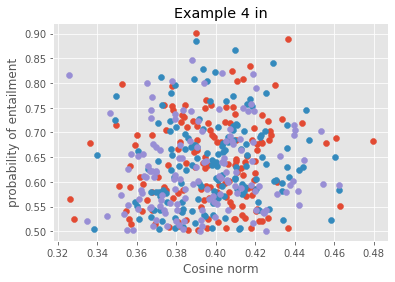

['ride', 'feeding', 'horse', 'ready', 'to'] 



100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


['ride', 'feeding', 'horse', 'ready', 'to'] 



100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


['ride', 'feeding', 'horse', 'ready', 'to'] 



100%|██████████| 200/200 [00:17<00:00, 11.59it/s]


| Min: 0.026928254881552347
Token: feeding | attention: 0.047406851330682294
Token: ride | attention: 0.046847829068528635
Token: ready | attention: 0.04640629159828475
Token: horse | attention: 0.04581101563510022
Token: to | attention: 0.04521189197107055


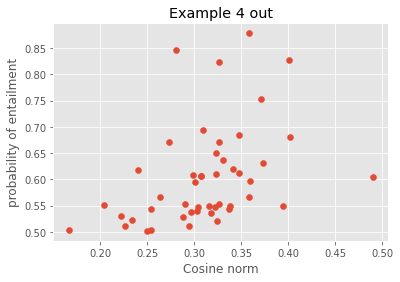





###### Example : 1 label entailment ########
['toy', 'couch', 'sits', 'mother', '.'] 



100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


['toy', 'couch', 'sits', 'mother', '.'] 



100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


['toy', 'couch', 'sits', 'mother', '.'] 



100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


| Min: 0.02434537234454928
Token: couch | attention: 0.0465687579811568
Token: sits | attention: 0.04170999715850775
Token: mother | attention: 0.033444577367360964
Token: toy | attention: 0.03149434153531572
Token: . | attention: 0.029980308645015084


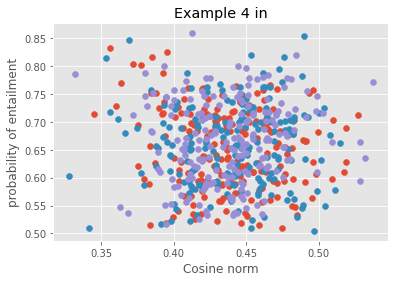

['mother', 'on', 'sits', 'his', 'watches'] 



100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


['mother', 'on', 'sits', 'his', 'watches'] 



100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


['mother', 'on', 'sits', 'his', 'watches'] 



100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


| Min: 0.016034192552525136
Token: mother | attention: 0.030468147715286983
Token: watches | attention: 0.030310317421553067
Token: on | attention: 0.030242847413022786
Token: his | attention: 0.029878103137249402
Token: sits | attention: 0.029748132417634486


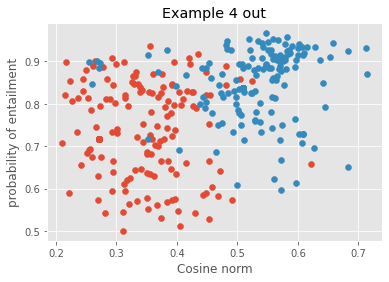





###### Example : 2 label entailment ########
['dogs', 'brown', 'grassy', 'enjoys', 'throws'] 



100%|██████████| 200/200 [00:29<00:00,  6.83it/s]


['dogs', 'brown', 'grassy', 'enjoys', 'throws'] 



100%|██████████| 200/200 [00:29<00:00,  6.78it/s]


['dogs', 'brown', 'grassy', 'enjoys', 'throws'] 



100%|██████████| 200/200 [00:28<00:00,  6.96it/s]


| Min: 0.03310311080688284
Token: grassy | attention: 0.052148828992219044
Token: dogs | attention: 0.04240817899452956
Token: throws | attention: 0.04198017465635017
Token: enjoys | attention: 0.041836097236366665
Token: brown | attention: 0.03969097343227117


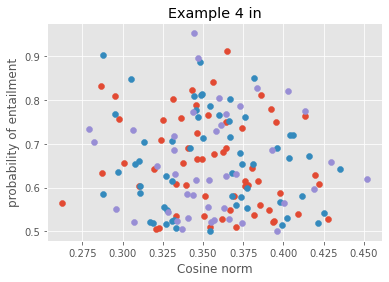

['throws', 'three', 'group', 'stick', 'field'] 



100%|██████████| 200/200 [00:34<00:00,  5.84it/s]


['throws', 'three', 'group', 'stick', 'field'] 



100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


['throws', 'three', 'group', 'stick', 'field'] 



100%|██████████| 200/200 [00:17<00:00, 11.54it/s]


| Min: 0.020573350381831047
Token: field | attention: 0.04093803330828163
Token: group | attention: 0.040334544268692915
Token: throws | attention: 0.03842530028488154
Token: three | attention: 0.0377171575485282
Token: stick | attention: 0.037714289269829705


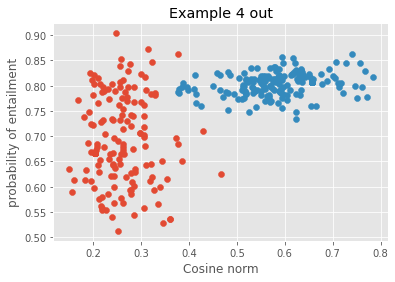

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[1], "entailment", 1, "Cosine",)





###### Example : 0 label contradiction ########
['kids', 'youths', 'emotional', 'very', 'related'] 



100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


['kids', 'youths', 'emotional', 'very', 'related'] 



100%|██████████| 200/200 [00:29<00:00,  6.68it/s]


['kids', 'youths', 'emotional', 'very', 'related'] 



100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


| Min: 0.02712838744282837
Token: emotional | attention: 0.04470819089540806
Token: related | attention: 0.03850161612666976
Token: kids | attention: 0.037807782396420964
Token: youths | attention: 0.03610767640374678
Token: very | attention: 0.034322224720395096


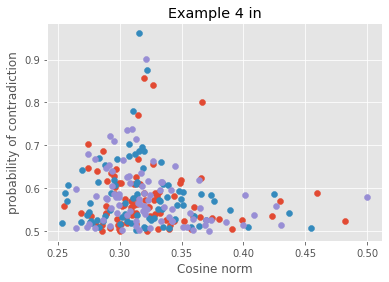

['them', 'with', 'are', '1', 'looking'] 



100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


['them', 'with', 'are', '1', 'looking'] 



100%|██████████| 200/200 [00:17<00:00, 11.57it/s]


['them', 'with', 'are', '1', 'looking'] 



100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


| Min: 0.019413457945082573
Token: 1 | attention: 0.032436888179008104
Token: them | attention: 0.032421198822471395
Token: are | attention: 0.03241444411930384
Token: with | attention: 0.03221437368908179
Token: looking | attention: 0.0318276013384602


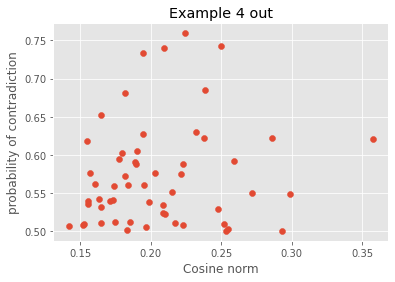





###### Example : 1 label contradiction ########
['white', 'wearing', 'shorts', 'blond', 'shirt'] 



100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


['white', 'wearing', 'shorts', 'blond', 'shirt'] 



100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


['white', 'wearing', 'shorts', 'blond', 'shirt'] 



100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


| Min: 0.02285472532371754
Token: blond | attention: 0.03674857174959557
Token: shirt | attention: 0.03548495524157451
Token: shorts | attention: 0.03537967512428578
Token: white | attention: 0.034306185806836115
Token: wearing | attention: 0.0322777709403757


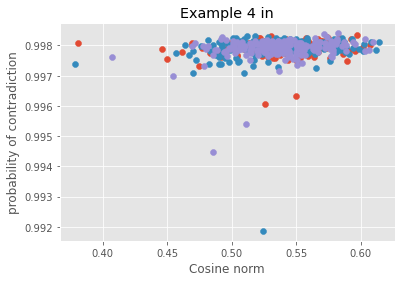

['sky', 'black', 'water', 'shorts', 'white'] 



100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


['sky', 'black', 'water', 'shorts', 'white'] 



100%|██████████| 200/200 [00:34<00:00,  5.74it/s]


['sky', 'black', 'water', 'shorts', 'white'] 



100%|██████████| 200/200 [00:17<00:00, 11.64it/s]


| Min: 0.014573194864188697
Token: white | attention: 0.0313230215112115
Token: black | attention: 0.030697207617879866
Token: water | attention: 0.03038908545203667
Token: shorts | attention: 0.030009657799132863
Token: sky | attention: 0.02973122899934312


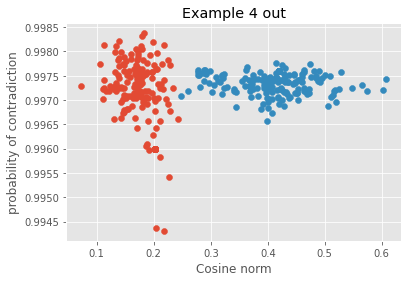





###### Example : 2 label contradiction ########
['wearing', 'blue', 'shorts', '.', 'dog'] 



100%|██████████| 200/200 [00:35<00:00,  5.71it/s]


['wearing', 'blue', 'shorts', '.', 'dog'] 



100%|██████████| 200/200 [00:35<00:00,  5.71it/s]


['wearing', 'blue', 'shorts', '.', 'dog'] 



100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


| Min: 0.03543986169216665
Token: shorts | attention: 0.05015926381563991
Token: wearing | attention: 0.04487756059744557
Token: dog | attention: 0.04337546417420318
Token: blue | attention: 0.04214548678831607
Token: . | attention: 0.03871311038265285


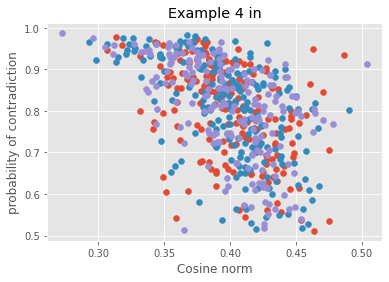

['g', 'walking', 'blue', '##rill', 'dog'] 



100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


['g', 'walking', 'blue', '##rill', 'dog'] 



100%|██████████| 200/200 [00:17<00:00, 11.66it/s]


['g', 'walking', 'blue', '##rill', 'dog'] 



100%|██████████| 200/200 [00:17<00:00, 11.64it/s]


| Min: 0.025797275538033307
Token: blue | attention: 0.044302236610586555
Token: g | attention: 0.04286069845749445
Token: ##rill | attention: 0.04227746182052774
Token: walking | attention: 0.04213871151098835
Token: dog | attention: 0.04208212343247379


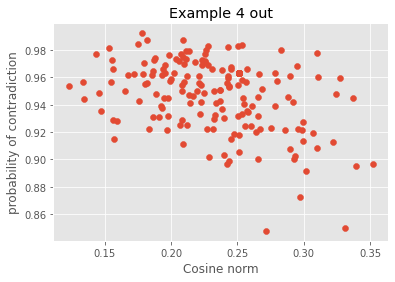

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[2], "contradiction", 2, "Cosine",)

In [ ]:
select_max_imp = 100

In [ ]:
def calculate_imp(true_logits, true_class, perturbed_logits, perturbed_class):
  if(perturbed_class == true_class):
    return true_logits[true_class] - perturbed_logits[true_class]
  return true_logits[true_class] - perturbed_logits[true_class] + true_logits[perturbed_class] - perturbed_logits[perturbed_class]

In [ ]:
print(tokenizer.decode([1532]))

form


In [ ]:
def intersection(a, b):
  cnt = 0;
  print(a)
  print(b)
  for i in range(min(len(a), len(b))):
      if(a[i] == b[i]):
          cnt += 1;
      
  return (cnt/min(len(a), len(b)))*100

In [ ]:
def find_intersection_top5(text_lab, label, label_ind, flag):
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i, (tokens, tokenized_threads) in enumerate(text_lab):
        print("\n\n\n")
        print("###### Example :", str(i), "label", label, "########")
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device).reshape((1, len(tokenized_threads)))
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
        
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        graph = dict()
        
        for tok in tokens:
            if(tok not in mapping_ind):
                mapping_ind[tok] = cnt;
                cnt += 1

        for lay in range(12):
            weights = attention[0, lay, :, :]
            for ind_1 in range(len(tokens)):
                for ind_2 in range(len(tokens)):
                    if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                        continue
                    node_1 = mapping_ind[tokens[ind_1]]
                    node_2 = mapping_ind[tokens[ind_2]]
                    rev_mapping_ind[node_1] = tokens[ind_1]
                    rev_mapping_ind[node_2] = tokens[ind_2]
                    weight = weights[ind_1, ind_2]
                    if(node_1 not in graph):
                        graph[node_1] = {}
                    if(node_2  not in graph[node_1]):
                        graph[node_1][node_2] = (weight, 1)
                    else:
                        graph[node_1][node_2] = ((weight + (graph[node_1][node_2][0])*graph[node_1][node_2][1])/(graph[node_1][node_2][1] + 1), graph[node_1][node_2][1] + 1)
        logits = predict_proba(tokenized_threads)
        class_assigned = torch.argmax(logits[0, :])
        topk_in, topk_out, topk_in_attention, topk_out_attention, topk_in_min, topk_out_min = find_topk_tokens(graph, select_max_imp)
        arr = tokenized_threads.cpu().detach().clone().numpy()

        candidates = []
        for j in range(len(tokens)):
          temp_tokenized_threads = np.concatenate([arr[0, : j], arr[0, j + 1:], np.array([tokenizer.pad_token_id])])
    
          temp_logits = predict_proba(torch.tensor(temp_tokenized_threads, device=device).reshape((1, len(temp_tokenized_threads))))

          temp_class_assigned = torch.argmax(temp_logits)

          importance_score = calculate_imp(logits[0], class_assigned, temp_logits[0], temp_class_assigned)
          candidates.append((arr[0, j], importance_score))
        candidates.sort(key = lambda x : x[1])
        candidates.reverse()
        print(candidates)
        print("intersection between in : ", intersection([tokenizer.decode(i[0]) for i in candidates[:select_max_imp] if tokenizer.decode(i[0]) not in ["[CLS]", "[PAD]", "[SEP]"]], [rev_mapping_ind[z] for z in topk_in]))
        print("intersection between out : ",intersection([tokenizer.decode(i[0]) for i in candidates[:select_max_imp] if tokenizer.decode(i[0]) not in ["[CLS]", "[PAD]","[SEP]"]], [rev_mapping_ind[z] for z in topk_out]))

In [ ]:

find_intersection_top5(text[2], "contradiction", 2, "Cosine",)





###### Example : 0 label contradiction ########
[(1296, tensor(0.1770, device='cuda:0', grad_fn=<SubBackward0>)), (101, tensor(0.1241, device='cuda:0', grad_fn=<SubBackward0>)), (101, tensor(0.1241, device='cuda:0', grad_fn=<SubBackward0>)), (1168, tensor(0.0816, device='cuda:0', grad_fn=<SubBackward0>)), (122, tensor(0.0552, device='cuda:0', grad_fn=<SubBackward0>)), (1105, tensor(0.0514, device='cuda:0', grad_fn=<SubBackward0>)), (123, tensor(0.0363, device='cuda:0', grad_fn=<SubBackward0>)), (2272, tensor(0.0273, device='cuda:0', grad_fn=<SubBackward0>)), (1702, tensor(0.0257, device='cuda:0', grad_fn=<SubBackward0>)), (1960, tensor(0.0250, device='cuda:0', grad_fn=<SubBackward0>)), (23149, tensor(0.0239, device='cuda:0', grad_fn=<SubBackward0>)), (1114, tensor(0.0230, device='cuda:0', grad_fn=<SubBackward0>)), (19558, tensor(0.0190, device='cuda:0', grad_fn=<SubBackward0>)), (5859, tensor(0.0171, device='cuda:0', grad_fn=<SubBackward0>)), (1103, tensor(0.0159, device='cuda:0', 

In [ ]:
find_intersection_top5(text[1], "entailment", 1, "L2",)





###### Example : 0 label entailment ########
[66, 68, 69, 23, 70, 72, 67, 63, 65, 64, 9, 62, 47, 71] [69, 67, 66, 70, 47, 68, 64, 65, 72, 71, 9, 63, 62, 23]
intersection between in :  7.142857142857142
intersection between out :  0.0




###### Example : 1 label entailment ########
[87, 86, 85, 83, 23, 73, 89, 84, 80, 82, 75, 90, 79, 78, 77, 74, 18, 5, 81, 88, 21, 8, 76, 1] [85, 89, 5, 82, 86, 87, 81, 21, 88, 83, 90, 84, 18, 1, 73, 79, 75, 8, 74, 76, 80, 23, 77, 78]
intersection between in :  0.0
intersection between out :  0.0




###### Example : 2 label entailment ########
[94, 93, 96, 92, 100, 97, 23, 99, 91, 95, 25, 9, 98, 26, 8, 36, 1] [95, 25, 96, 99, 97, 9, 26, 93, 100, 91, 98, 92, 8, 94, 1, 36, 23]
intersection between in :  5.88235294117647
intersection between out :  0.0


In [ ]:
find_intersection_top5(text[0], "neutral", 0, "L2")





###### Example : 0 label neutral ########
intersection between in :  35.08771929824561
intersection between out :  35.08771929824561




###### Example : 1 label neutral ########
intersection between in :  36.84210526315789
intersection between out :  36.84210526315789




###### Example : 2 label neutral ########
intersection between in :  40.35087719298245
intersection between out :  40.35087719298245


In [ ]:
def remove_padding(x):
    ret = []
    for i in x[::-1]:
        if(i == "[PAD]"):
            continue
        else:
            ret.append(i)
    ret = ret[::-1]
    return ret

In [ ]:
for i, sent in enumerate(text):
    text[i] = remove_padding(sent)


In [ ]:
color = ["\033[1;31;47m", "\033[1;32;47m", "\033[1;33;47m", 
         "\033[1;34;47m", "\033[1;35;47m", "\033[1;36;47m",
         "\033[1;37;47m"]
mapping = ["Red", "Green", "Yellow", "Blue", "Purple", "Cyan", "White"]


In [ ]:
print("\033[1;32;47m" + text[0][0])

In [ ]:
reverse_mapping = {}
for i in mapping_ind:
    reverse_mapping[mapping_ind[i]] = i

In [ ]:
tokens = []
for lay in range(12):
    for i in graph_attention[lay]:
        l = 0
        for j in graph_attention[lay][i]:
            l += graph_attention[lay][i][j][0]
        l /= len(graph_attention[lay][i])
        tokens.append((l, reverse_mapping[i]))


In [ ]:
tokens_high_deg = []
for lay in range(12):
    for i in graph_attention[lay]:
        tokens_high_deg.append((len(graph_attention[lay][i]), reverse_mapping[i]))

In [ ]:
tokens.sort(reverse = True)
tokens_high_deg.sort(reverse = True)

In [ ]:
print(tokens[:10])
print(tokens_high_deg[:10])

In [ ]:
factor = 40
factor_2 = 20

In [ ]:
Truetop_tok = [i[1] for i in tokens[:len(mapping)*factor]]
top_tok_deg = [i[1] for i in tokens_high_deg[:len(mapping)*factor_2]]


In [ ]:
def parse_top_k(l, length):
    ret = []
    ind = 0
    mapping_check = {}
    while(len(ret) != length and ind < len(l)):
        if(l[ind][1] in mapping_check):
            ind += 1
            continue
        mapping_check[l[ind][1]] = 1
        ret.append(l[ind][1])
        ind += 1
    return ret
top_tok = parse_top_k(tokens, len(mapping)*factor)

top_tok_deg = parse_top_k(tokens_high_deg, len(mapping)*factor_2)

In [ ]:
print("Attention")
print(top_tok)
print("Degree ")
print(top_tok_deg)

In [ ]:
print(len(top_tok_deg))

In [ ]:
print(set(top_tok))


In [ ]:
print(set(top_tok_deg))

In [ ]:
def masking_text(tok, text, color):
    for i in range(len(text)):
        print("\t ###################### Example " + str(i) + " ##############")
        print("")
        masked_text = []
        for j in text[i]:
            flag = 0
            for ind in range(len(tok)):
                if(j == tok[ind]):
                    masked_text.append(color[ind//factor] + j + "\x1b[0m")
                    flag = 1
                    break
            if(flag == 0):
                masked_text.append(j)
        print(" ".join(masked_text))   
        
        print("")

In [ ]:
print("\t ####### Mapping for high attention value \n \n")
for i in range(len(mapping)):
    print(color[i], mapping[i], " : ", top_tok[i*factor : (i + 1)*factor])

In [ ]:
for i in range(len(mapping)):
    print(mapping[i], " : ", "(attention value) priority top : ", str(i*factor), "-", str((i + 1)*factor))

In [ ]:
print(masking_text(top_tok, text, color))

In [ ]:
print("\t ####### Mapping for Degree value \n \n")
for i in range(len(mapping)):
    print(color[i] ,mapping[i], " : ", top_tok_deg[i*factor_2 : (i + 1)*factor_2])

In [ ]:
for i in range(len(mapping)):
    print(mapping[i], " : ", "(degree) priority top : ", str(i*factor), "-", str((i + 1)*factor_2))

In [ ]:
print(masking_text(top_tok_deg, text, color))

In [ ]:
print(set(i[1] for i in tokens[:100]))

In [ ]:
print(set(i[1] for i in tokens_high_deg[:200]))

In [ ]:
import matplotlib.pyplot as plt

def plot_degree_dist(degrees):
    plt.hist(degrees)
    plt.show()


In [ ]:
for lay in range(12):
    degree = []
    for i in graph_attention[lay]:
        degree.append(len(graph_attention[lay][i]))
    degree.sort(reverse = True)
    plot_degree_dist(degree)
    